# Описание проекта

В распоряжении есть данные Яндекс.Музыки о поведении пользователей из Москвы и Санкт-Петербурга.

**Цель исследования** — проверить три гипотезы:
1. Активность пользователей зависит от дня недели. Причём в Москве и Петербурге это проявляется по-разному.
2. В понедельник утром в Москве преобладают одни жанры, а в Петербурге — другие. Так же и вечером пятницы преобладают разные жанры — в зависимости от города. 
3. Москва и Петербург предпочитают разные жанры музыки. В Москве чаще слушают поп-музыку, в Петербурге — русский рэп.

**Ход исследования:**
1. [Обзор данных](#first);
2. [Предобработка данных](#second);
3. [Сравнение пользователей Москвы и Санкт-Петербурга](#third);
4. [Выводы](#conclusion)

## Обзор данных
<a id="first"></a>

In [1]:
%config InlineBackend.figure_format='retina'

import pandas as pd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('yandex_music_project.csv')
display(df.head())
df.info()

,userID,Track,artist,genre,City,time,Day
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Saint-Petersburg,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Moscow,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Saint-Petersburg,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Saint-Petersburg,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,dance,Moscow,08:34:34,Monday


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     userID  65079 non-null  object
 1   Track     63848 non-null  object
 2   artist    57876 non-null  object
 3   genre     63881 non-null  object
 4     City    65079 non-null  object
 5   time      65079 non-null  object
 6   Day       65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


In [3]:
df.describe()

,userID,Track,artist,genre,City,time,Day
count,65079,63848,57876,63881,65079,65079,65079
unique,41748,47245,43605,289,2,20392,3
top,A8AE9169,Intro,Plan B,pop,Moscow,08:14:07,Friday
freq,76,34,6,8850,45360,14,23149


**Выводы**

В каждой строке таблицы — данные о прослушанном треке. Часть колонок описывает саму композицию: название, исполнителя и жанр. Остальные данные рассказывают о пользователе: из какого он города, когда слушал музыку. <br>
В данных содержатся пропуски, есть пробелы в названии столбцов.

## Предобработка данных
<a id="second"></a>

### Стиль заголовков

In [4]:
df.columns

Index(['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day'], dtype='object')

In [5]:
# переводим названия заголовков в snake_case, убираем пробелы
df = df.rename(columns={'  userID':'user_id', 'Track':'track', '  City  ':'city', 'Day':'day'})

### Обработка пропусков

In [6]:
# выводим процент пропусков
display(pd.DataFrame(round((df.isna().mean()*100),2), columns=['NaNs, %']).style.format(
    '{:.2f}').background_gradient('coolwarm'))

,"NaNs, %"
user_id,0.00
track,1.89
artist,11.07
genre,1.84
city,0.00
time,0.00
day,0.00


Пропуски в `track` и `artist` не повлияют на результаты исследования, возможно заменить их "заглушкой". <br>
Пропуски в `genre` могут помешать сравнению музыкальных вкусов в Москве и Санкт-Петербурге. Однако учитывая невысокий процент пропусков, также заменим "заглушкой" и в ходе дальнейшего исследования определим степень влияния на выводы исследования.

In [7]:
columns_to_replace = ['track', 'artist', 'genre']
for i in columns_to_replace:
    df[i] = df[i].fillna('unknown')

In [8]:
# убедимся, что в таблице не осталось пропусков
df.isna().sum()

user_id    0
track      0
artist     0
genre      0
city       0
time       0
day        0
dtype: int64

### Дубликаты

In [9]:
# считаем явные дубликаты
df.duplicated().sum()

3826

In [10]:
# удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)

Далее проанализируем наличие неявных дубликатов в колонке `genre`. Например, название одного и того же жанра может быть записано немного по-разному.

In [11]:
# выводим список уникальных названий жанров
genres = df['genre'].sort_values().unique()
genres

array(['acid', 'acoustic', 'action', 'adult', 'africa', 'afrikaans',
       'alternative', 'alternativepunk', 'ambient', 'americana',
       'animated', 'anime', 'arabesk', 'arabic', 'arena',
       'argentinetango', 'art', 'audiobook', 'author', 'avantgarde',
       'axé', 'baile', 'balkan', 'beats', 'bigroom', 'black', 'bluegrass',
       'blues', 'bollywood', 'bossa', 'brazilian', 'breakbeat', 'breaks',
       'broadway', 'cantautori', 'cantopop', 'canzone', 'caribbean',
       'caucasian', 'celtic', 'chamber', 'chanson', 'children', 'chill',
       'chinese', 'choral', 'christian', 'christmas', 'classical',
       'classicmetal', 'club', 'colombian', 'comedy', 'conjazz',
       'contemporary', 'country', 'cuban', 'dance', 'dancehall',
       'dancepop', 'dark', 'death', 'deep', 'deutschrock', 'deutschspr',
       'dirty', 'disco', 'dnb', 'documentary', 'downbeat', 'downtempo',
       'drum', 'dub', 'dubstep', 'eastern', 'easy', 'electronic',
       'electropop', 'emo', 'entehno', '

Используем библиотеку FuzzyWuzzy для поиска сходства между словами (используется расстояние Левенштейна). Возьмем границу индекса сходства не менее 80.

In [12]:
# каждое слово из genres сравним со всеми словами genres и отфильтруем по индексу сходства
for genre in genres:
    for i in range(len(genres)):
        ratio = fuzz.WRatio(genre, genres[i])
        if 80 <= ratio < 100:
            print(f'{genre} - {genres[i]}')

alternative - alternativepunk
alternative - native
alternative - rockalternative
alternativepunk - alternative
alternativepunk - native
alternativepunk - punk
argentinetango - tango
axé - relax
beats - downbeat
beats - worldbeat
cantopop - pop
cantopop - top
chanson - shanson
classical - classicmetal
classicmetal - classical
classicmetal - metal
conjazz - jazz
cuban - urban
dance - dancehall
dance - dancepop
dance - popdance
dance - popeurodance
dancehall - dance
dancepop - dance
dancepop - pop
deutschrock - rock
downbeat - beats
dub - dubstep
dubstep - dub
eastern - western
electronic - loungeelectronic
electronic - popelectronic
electropop - pop
epicmetal - metal
eurofolk - folk
extrememetal - metal
folk - eurofolk
folk - folklore
folk - folkmetal
folk - folkrock
folk - folktronica
folklore - folk
folkmetal - folk
folkmetal - metal
folkrock - folk
folkrock - rock
folktronica - folk
hardcore - posthardcore
hardtechno - tech
hardtechno - techno
hip - hip-hop
hip - hiphop
hip-hop - hip


Можно заметить следующие неявные дубликаты:
- жанр hiphop (hip, hop, hip-hop)
- жанр chanson (shanson)
- жанр latino (latin)
- жанр türk (türkçe) 

In [13]:
# исправим названия жанров
df['genre'] = (
    df['genre']
    .replace('hip', 'hiphop')
    .replace('hop', 'hiphop')
    .replace('hip-hop', 'hiphop')
    .replace('shanson', 'chanson')
    .replace('latin', 'latino')
    .replace('türkçe', 'türk')
)

**Выводы**

В ходе преодобработки приведены к одному стилю названия колонок, пропуски заменены на "unknown", обработаны явные и неявные дубликаты.

## Сравнение пользователей Москвы и Санкт-Петербурга
<a id="third"></a>

### Сравнение поведения пользователей двух столиц

Первая гипотеза утверждает, что пользователи по-разному слушают музыку в Москве и Санкт-Петербурге. Проверим это предположение по данным о трёх днях недели — понедельнике, среде и пятнице.


In [14]:
df.pivot_table(index=['city', 'day'], values='track', aggfunc='count').sort_values('track', ascending=False)

track
city             day             
Moscow           Friday     15945
                 Monday     15740
                 Wednesday  11056
Saint-Petersburg Wednesday   7003
                 Friday      5895
                 Monday      5614

**Выводы**

Данные показывают разницу поведения пользователей:

- В Москве пик прослушиваний приходится на пятницу и понедельник, а в среду заметен спад.
- В Петербурге, наоборот, больше слушают музыку по средам. Активность в понедельник и пятницу здесь почти в равной мере уступает среде.

Значит, данные говорят в пользу первой гипотезы.

### Музыка в начале и в конце недели

Согласно второй гипотезе, утром в понедельник в Москве преобладают одни жанры, а в Петербурге — другие. Так же и вечером пятницы преобладают разные жанры — в зависимости от города.

In [15]:
def get_top_genres(city, time_start, time_end, day):
    
    result = df.query('time >= @time_start and time <= @time_end \
                     and city == @city \
                     and day == @day') \
                    ['genre'].value_counts().head(10)
    return result

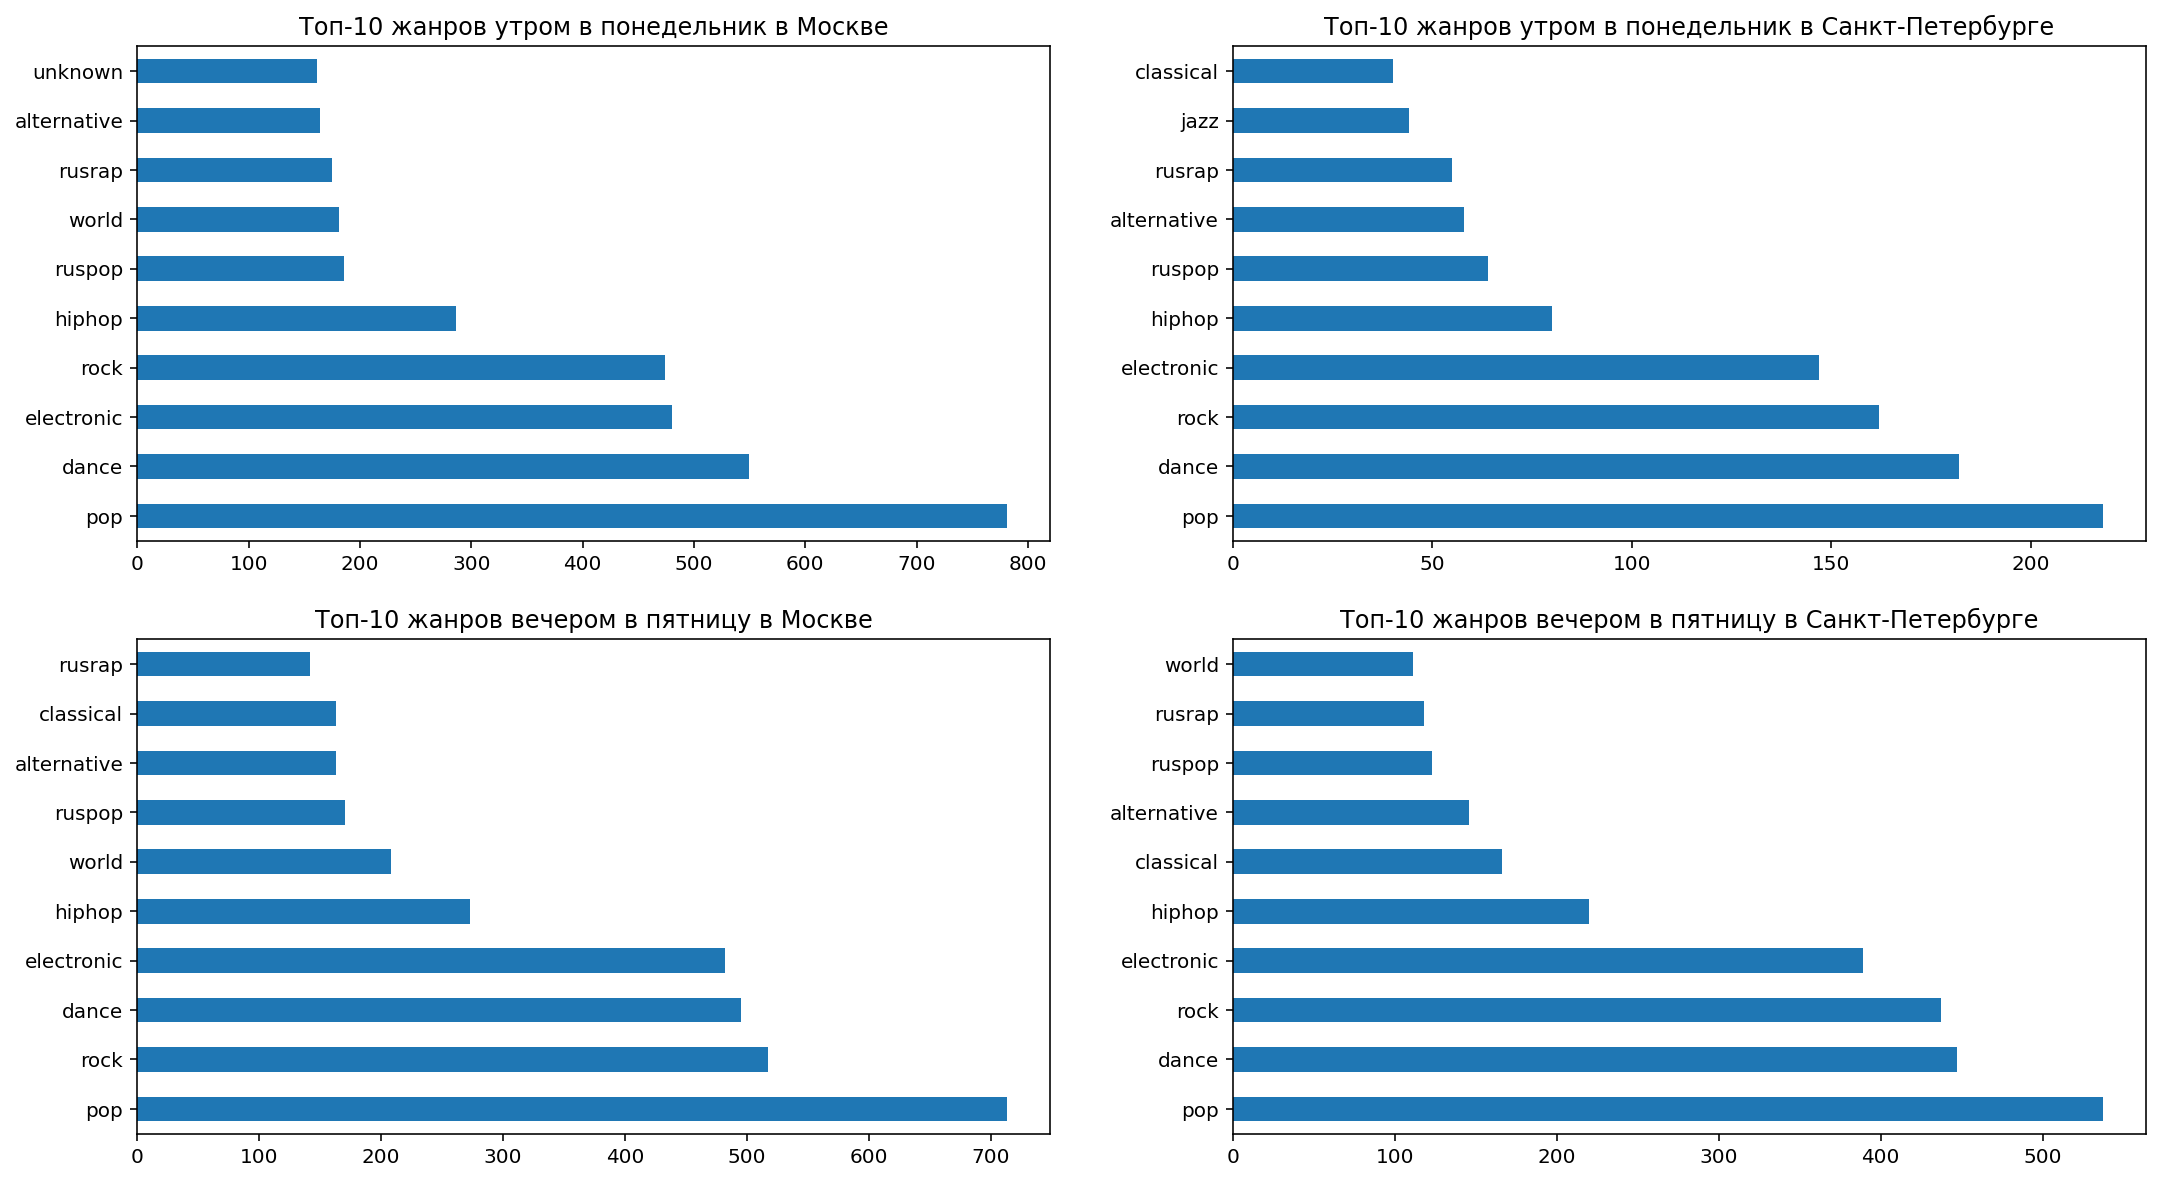

In [16]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


get_top_genres('Moscow', '07:00:00', '11:00:00', 'Monday') \
.plot(kind='barh', ax=ax1, title='Топ-10 жанров утром в понедельник в Москве')
get_top_genres('Saint-Petersburg', '07:00:00', '11:00:00', 'Monday') \
.plot(kind='barh', ax=ax2, title='Топ-10 жанров утром в понедельник в Санкт-Петербурге')
get_top_genres('Moscow', '17:00:00', '23:00:00', 'Friday') \
.plot(kind='barh', ax=ax3, title='Топ-10 жанров вечером в пятницу в Москве')
get_top_genres('Saint-Petersburg', '12:00:00', '23:00:00', 'Friday') \
.plot(kind='barh', ax=ax4, title='Топ-10 жанров вечером в пятницу в Санкт-Петербурге')
plt.show()

**Выводы**

Если сравнить топ-10 жанров в понедельник утром, можно сделать такие выводы:

1. В Москве и Петербурге слушают похожую музыку. Единственное отличие — в московский рейтинг вошёл жанр “world”, а в петербургский — джаз и классика.

2. В Москве пропущенных значений оказалось так много, что значение `'unknown'` заняло десятое место среди самых популярных жанров. Значит, пропущенные значения занимают существенную долю в данных и угрожают достоверности исследования.

Вечер пятницы не меняет эту картину. Некоторые жанры поднимаются немного выше, другие спускаются, но в целом топ-10 остаётся тем же самым.

Таким образом, вторая гипотеза подтвердилась лишь частично:
* Пользователи слушают похожую музыку в начале недели и в конце.
* Разница между Москвой и Петербургом не слишком выражена. В Москве чаще слушают русскую популярную музыку, в Петербурге — джаз.

Однако пропуски в данных ставят под сомнение этот результат. В Москве их так много, что рейтинг топ-10 мог бы выглядеть иначе, если бы не утерянные  данные о жанрах.

### Жанровые предпочтения в Москве и Петербурге

Гипотеза: Петербург — столица рэпа, музыку этого жанра там слушают чаще, чем в Москве.  А Москва — город контрастов, в котором, тем не менее, преобладает поп-музыка.

In [17]:
df.query('city == "Moscow"') \
.pivot_table(index='genre', values='user_id', aggfunc='count') \
.sort_values('user_id', ascending=False).head(10)

,user_id
genre,
pop,5892
dance,4435
rock,3965
electronic,3786
hiphop,2096
classical,1616
world,1432
alternative,1379
ruspop,1372


In [18]:
df.query('city == "Saint-Petersburg"') \
.pivot_table(index='genre', values='user_id', aggfunc='count') \
.sort_values('user_id', ascending=False).head(10)

,user_id
genre,
pop,2431
dance,1932
rock,1879
electronic,1736
hiphop,960
alternative,649
classical,646
rusrap,564
ruspop,538


**Выводы**

Гипотеза частично подтвердилась:
* Поп-музыка — самый популярный жанр в Москве, как и предполагала гипотеза. Более того, в топ-10 жанров встречается близкий жанр — русская популярная музыка.
* Вопреки ожиданиям, рэп одинаково популярен в Москве и Петербурге. 


## Выводы
<a id="conclusion"></a>

Были проверены три гипотезы:

1. День недели по-разному влияет на активность пользователей в Москве и Петербурге. 

Первая гипотеза полностью подтвердилась.

2. Музыкальные предпочтения не сильно меняются в течение недели — будь то Москва или Петербург. Небольшие различия заметны в начале недели, по понедельникам:
* в Москве слушают музыку жанра “world”,
* в Петербурге — джаз и классику.

Таким образом, вторая гипотеза подтвердилась лишь отчасти. Этот результат мог оказаться иным, если бы не пропуски в данных.

3. Во вкусах пользователей Москвы и Петербурга больше общего чем различий. Вопреки ожиданиям, предпочтения жанров в Петербурге напоминают московские.

Третья гипотеза не подтвердилась. Если различия в предпочтениях и существуют, на основной массе пользователей они незаметны.